# Installation

In [ ]:
! pip install pandas==0.23.4
! pip install keras==2.3.1
! pip install termcolor==1.1.0
! pip install six==1.16.0
! pip install tensorflow==1.13.1
! pip install numpy==1.16.2
! pip install matplotlib==2.2.4
! pip install scikit-learn==0.24.2
! pip install h5py==2.10.0
! pip install git+https://www.github.com/keras-team/keras-contrib.git

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Load Library

In [2]:
import sys
import os
import json
import numpy as np

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Dense
from keras.layers import GRU, LSTM, Bidirectional
from keras.layers import Embedding, TimeDistributed, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras_contrib.layers.crf import CRF

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from operator import itemgetter

Using TensorFlow backend.


# Data Processing

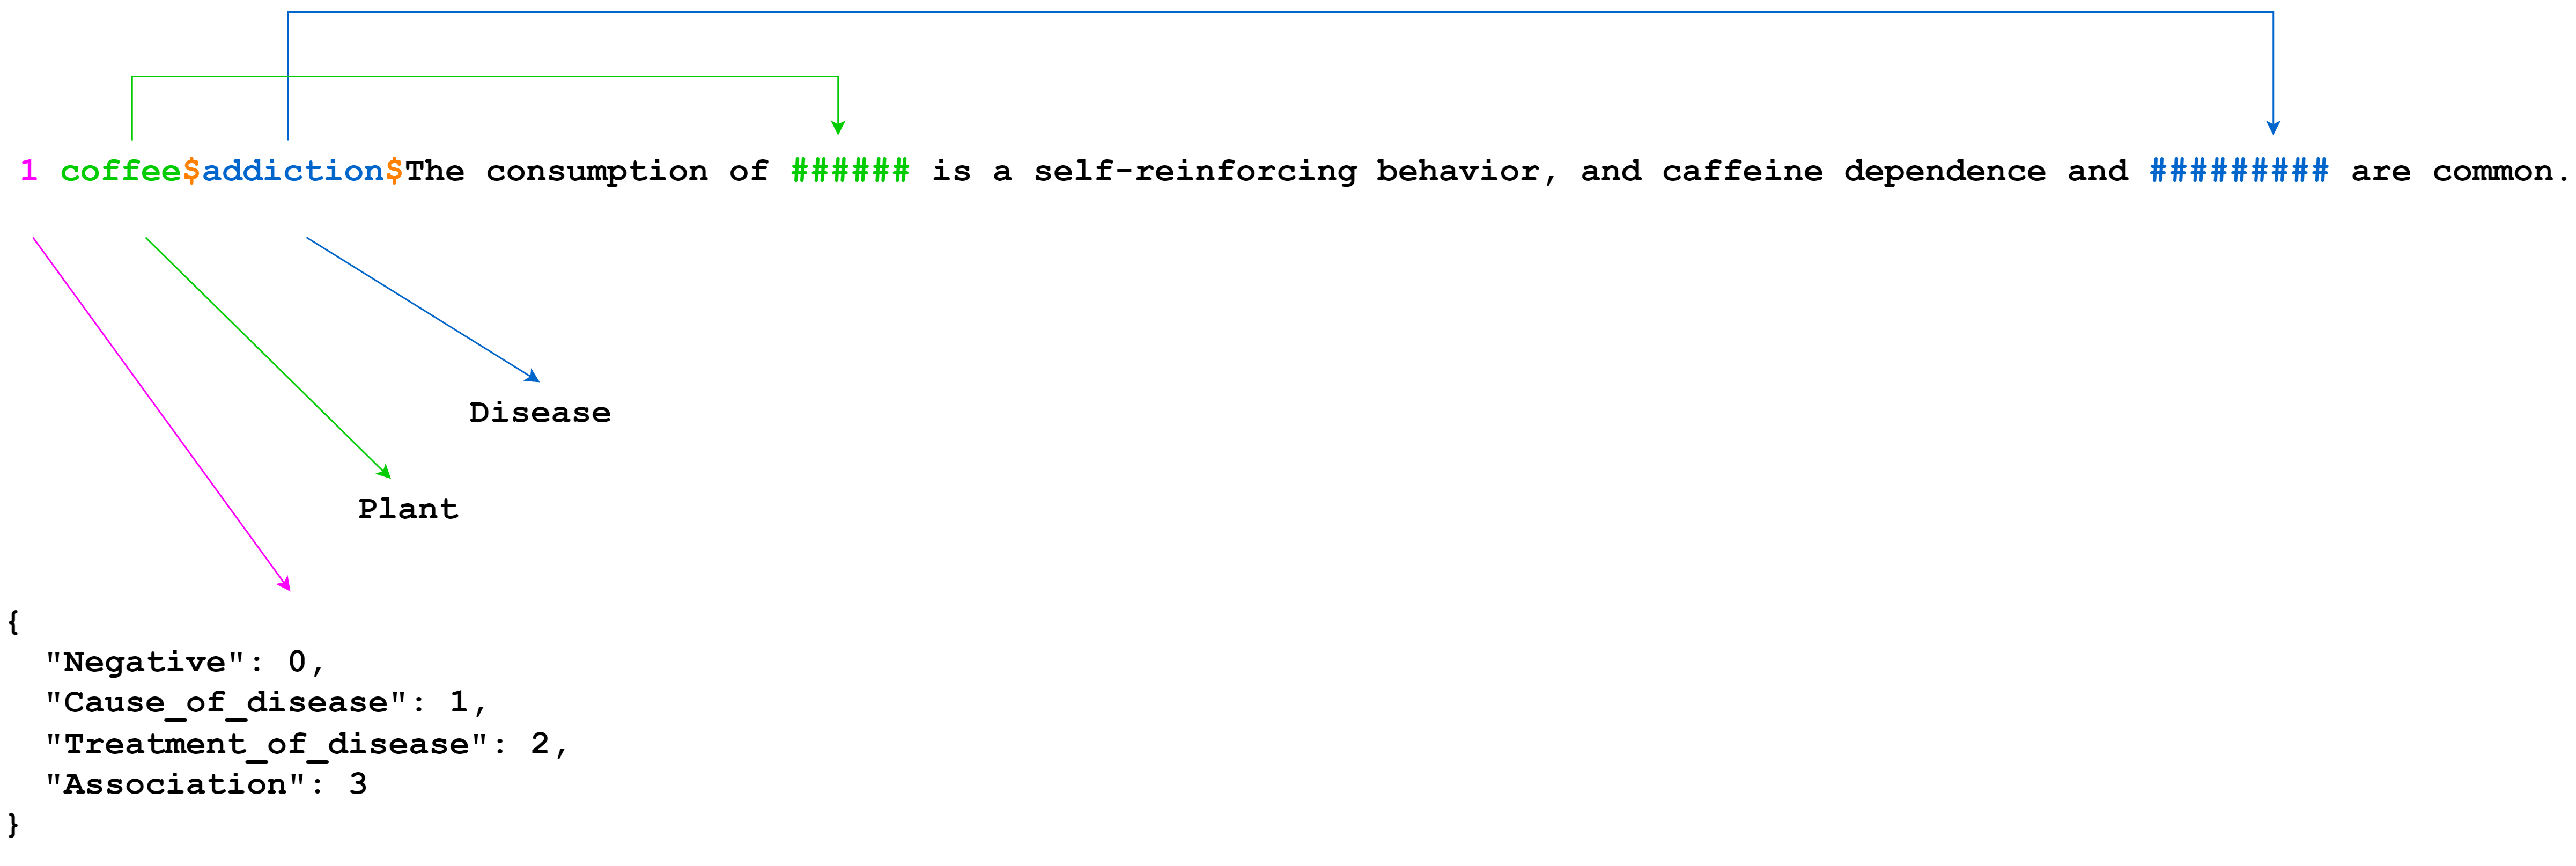

In [3]:
from IPython import display
display.Image("XtoT.png")

In [3]:
py_file_location = ""
sys.path.append(os.path.abspath(py_file_location))

In [4]:
from utils.load_data import get_train_test_pd
from utils.extract_feature import BertVector
from utils.att import Attention
from utils.crf import CRF

# Training

## Encoding Process

In [5]:
train_df, test_df = get_train_test_pd()
#train_df = get_train_test_pd()
bert_model = BertVector(pooling_strategy="NONE", max_seq_len=512)
print('begin encoding')
f = lambda text: bert_model.encode([text])["encodes"][0]

train_df['x'] = train_df['text'].apply(f)
test_df['x'] = test_df['text'].apply(f)
print('end encoding')

I:PROCESS:[graph:opt: 49]:model config: /Users/slametriyanto/Documents/MyApp/Dissertation_Project/BILSTM_CRF_RE/multi_cased_L-12_H-768_A-12/bert_config.json
I:PROCESS:[graph:opt: 55]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:PROCESS:[graph:opt:132]:load parameters from checkpoint...
I:PROCESS:[graph:opt:134]:freeze...
I:PROCESS:[graph:opt:137]:optimize...
I:PROCESS:[graph:opt:148]:write graph to a tmp file: tmp_graph21


begin encoding
end encoding


## Training Set

In [24]:
x_train = np.array([vec for vec in train_df['x']])
x_test = np.array([vec for vec in test_df['x']])
y_train = np.array([vec for vec in train_df['label']])
y_test = np.array([vec for vec in test_df['label']])

print('x_train: ', x_train.shape)
print('y_train: ', y_train.shape)
print('x_test: ', x_test.shape)
print('y_test: ', y_test.shape)

x_train:  (1177, 512, 768)
y_train:  (1177,)
x_test:  (130, 512, 768)
y_test:  (130,)


In [25]:
num_classes = 4 # {cause of disease, treatment of disease, association, negative}

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [26]:
print("Size of training input data : ", x_train.shape)
print("Size of training output data : ", y_train.shape)
print("Size of testing input data : ", x_test.shape)
print("Size of testing output data : ", y_test.shape)

Size of training input data :  (1177, 512, 768)
Size of training output data :  (1177, 4)
Size of testing input data :  (130, 512, 768)
Size of testing output data :  (130, 4)


# Save Model

In [27]:
# Save the latest val_acc best model file
filepath="output/e10-dr3-20b/epoch-{epoch:02d}-val_los-{val_loss:.4f}-acc-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Model Configuration

In [28]:
inputs = Input(name="Input", shape=(512, 768, ))
bilstm = Bidirectional(LSTM(128, dropout=0.3, return_sequences=True, name="Long-Short-Term-Memory"), name="Bidirectional")(inputs)
#attention = Attention(32, name="CRF-Attention")(bilstm)
crf = CRF(num_classes, name="Conditional-Random-Field")(bilstm)
dense = Dense(num_classes, activation='softmax', name="Output")(crf)

#dense = Dense(num_classes, activation='softmax', name="Output")(crf)

model = Model(inputs, dense, name="Relation-Extraction-BiLSTM-CRF")

# Model Visualization

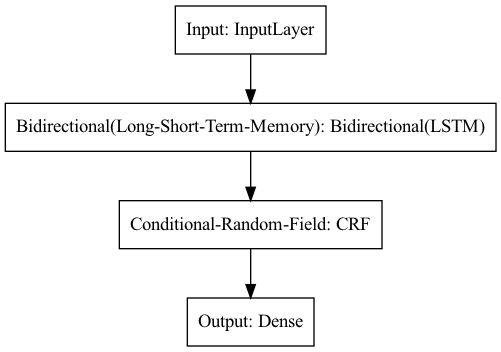

In [15]:
plot_model(model, to_file='model.png')

# Model Process

In [29]:
model.summary()

Model: "Relation-Extraction-BiLSTM-CRF"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 512, 768)          0         
_________________________________________________________________
Bidirectional (Bidirectional (None, 512, 256)          918528    
_________________________________________________________________
Conditional-Random-Field (CR (None, 256)               1540      
_________________________________________________________________
Output (Dense)               (None, 4)                 1028      
Total params: 921,096
Trainable params: 921,096
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
# Save the latest val_acc best model file
filepath="output/e10-dr3-20b/epoch-{epoch:02d}-val_los-{val_loss:.4f}-acc-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [35]:
history = model.fit(
    x_train, y_train, 
    validation_data=(x_test, y_test), 
    batch_size=8, 
    epochs=10,
    shuffle=True,
    callbacks=[checkpoint]) 
    #callbacks=[early_stopping, checkpoint])

Train on 1177 samples, validate on 130 samples
Epoch 1/10
1177/1177 [==============================] - 73s 62ms/step - loss: 0.4337 - accuracy: 0.7887 - val_loss: 0.4273 - val_accuracy: 0.7885

Epoch 00001: val_accuracy improved from -inf to 0.78846, saving model to output/e10-dr3-20b/epoch-01-val_los-0.4273-acc-0.7885.hdf5
Epoch 2/10
1177/1177 [==============================] - 75s 64ms/step - loss: 0.3747 - accuracy: 0.8231 - val_loss: 0.4051 - val_accuracy: 0.7981

Epoch 00002: val_accuracy improved from 0.78846 to 0.79808, saving model to output/e10-dr3-20b/epoch-02-val_los-0.4051-acc-0.7981.hdf5
Epoch 3/10
1177/1177 [==============================] - 77s 65ms/step - loss: 0.3337 - accuracy: 0.8452 - val_loss: 0.4641 - val_accuracy: 0.7750

Epoch 00003: val_accuracy did not improve from 0.79808
Epoch 4/10
1177/1177 [==============================] - 80s 68ms/step - loss: 0.2869 - accuracy: 0.8751 - val_loss: 0.4091 - val_accuracy: 0.8077

Epoch 00004: val_accuracy improved from 0.7

# Accuracy and Loss

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


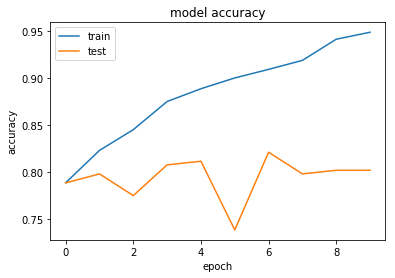

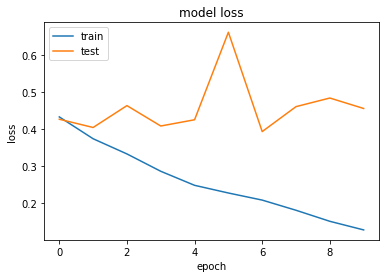

In [36]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Statistic

In [41]:
# Create pandas DataFrame
import pandas as pd

df_history = pd.DataFrame(history.history)
print(df_history)

   val_loss  val_accuracy      loss  accuracy
0  0.427340      0.788462  0.433663  0.788658
1  0.405096      0.798077  0.374699  0.823067
2  0.464121      0.775000  0.333714  0.845157
3  0.409096      0.807692  0.286889  0.875106
4  0.425945      0.811538  0.248975  0.888700
5  0.662195      0.738462  0.228243  0.900170
6  0.394053      0.821154  0.209091  0.909303
7  0.461392      0.798077  0.181623  0.918862
8  0.484616      0.801923  0.151824  0.941376
9  0.456375      0.801923  0.128579  0.948811


In [45]:
print('The effect on the test set：', model.evaluate(x_test, y_test))

130/130 [==============================] - 3s 22ms/step
The effect on the test set： [0.40136528381934533, 0.8038461804389954]


# Precission, Recall

In [38]:
with open('input/rel_dict.json', 'r', encoding='utf-8') as f:
    label_id_dict = json.loads(f.read())

sorted_label_id_dict = sorted(label_id_dict.items(), key=itemgetter(1))
values = [_[0] for _ in sorted_label_id_dict]

In [44]:
model = load_model(
  "output/e10-dr5-10/epoch-03-val_los-0.8693-acc-0.7710.hdf5", 
  custom_objects={"CRF": CRF})

y_pred = model.predict(x_test, batch_size=8)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=values))

                      precision    recall  f1-score   support

            Negative       0.67      0.24      0.35        58
    Cause_of_disease       0.92      0.61      0.73        18
Treatment_of_disease       0.49      0.94      0.65        51
         Association       0.00      0.00      0.00         3

            accuracy                           0.56       130
           macro avg       0.52      0.45      0.43       130
        weighted avg       0.62      0.56      0.51       130



# 10-Fold Cross Validation

In [69]:
from random import randint
from linereader import dopen

length = 1045
filename = 'input/fold0/Alldata.txt'

file = dopen(filename)
random_line = file.getline(randint(4, length))

In [70]:
print(random_line[20])

a
